### Import Libraries

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from math import sqrt
from sklearn.model_selection import train_test_split  
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import randint, uniform
import xgboost as xgb

In [66]:
# Load the historical delivery data from the CSV file into a DataFrame
data = pd.read_csv(r'C:\Users\User\Desktop\Lighthouse BootCamp\FINAL PROJECT\Doordash_historical_data.csv')

In [67]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


# Data Preprocessing

In [68]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime objects
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])

In [69]:
# Calculate the target variable 'delivery_duration_seconds'
data['delivery_duration_seconds'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()

In [70]:
# Add day of the week and hour columns
data['create_DOW'] = data['created_at'].dt.dayofweek
data['create_hr'] = data['created_at'].dt.hour

# Exploratory Data Analysis

In [71]:
# Basic statistics and information about the dataset
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 19 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

In [72]:
# Identify numeric columns 
numeric_columns = data.select_dtypes(include='number')

# Create a condition to replace negative values with NaN in numeric columns
condition = numeric_columns < 0

# Apply the condition to replace negative values with NaN
data[numeric_columns.columns] = np.where(condition, np.nan, data[numeric_columns.columns])

In [73]:
# Check for missing values in the data DataFrame
missing_values = data.isnull().sum()

# Display columns with missing values and their respective counts
print("Columns with Missing Values:")
print(missing_values[missing_values > 0])

Columns with Missing Values:
market_id                                         987
actual_delivery_time                                7
store_primary_category                           4760
order_protocol                                    995
min_item_price                                     13
total_onshift_dashers                           16283
total_busy_dashers                              16283
total_outstanding_orders                        16306
estimated_store_to_consumer_driving_duration      526
delivery_duration_seconds                           7
dtype: int64


### Missing Value Processing Strategies

**market_id**: 

Strategy: Drop rows with missing 'market_id' values.

Rationale: 'market_id' represents the city or region and is essential for analysis. Dropping rows with missing 'market_id' values is suitable if there are relatively few missing values.

**actual_delivery_time**: 

Strategy: Drop rows with missing 'actual_delivery_time' values (assuming these represent canceled deliveries).

Rationale: If missing 'actual_delivery_time' values indicate canceled deliveries, removing these rows makes sense to focus on completed deliveries.

**store_primary_category**:

Strategy: Use a separate category like 'Other' to represent missing values.

Rationale: Creating a separate category helps to retain information about missing values without skewing the analysis by imputing them with other categories.

**order_protocol**: 

Strategy: Create a separate category for missing values.

Rationale: Similar to 'store_primary_category,' creating a separate category for missing values is a clean way to handle them while preserving the information.

**min_item_price**: 

Strategy: Delete rows with missing values.

Rationale: The 'min_item_price' column has a small number of missing values (9 out of 129,389 rows), which represents a very small portion of the dataset (less than 0.01%).The missing values in this column are not expected to have a significant impact on the analysis or modeling task, as they constitute a very small fraction of the overall data.

**total_onshift_dashers, total_busy_dashers, total_outstanding_orders, estimated_store_to_consumer_driving_duration**: 

Strategy: Fill missing values with the same market and the same created hour or with the average of non-missing values within the same market and created hour.

Rationale: Imputing missing values based on market and created hour is a reasonable strategy, as it captures potential dependencies related to location and time.

In [74]:
# Strategy 1: Remove rows with any missing values in the specified columns
columns_to_remove_missing = ['market_id', 'actual_delivery_time']
data.dropna(subset=columns_to_remove_missing, inplace=True)

# Strategy 2: Fill missing 'store_primary_category' values with 'Other'
data['store_primary_category'].fillna('Other', inplace=True)

# Strategy 3: Create a separate category 'Missing' for missing 'order_protocol' values
data['order_protocol'].fillna('8', inplace=True)

# Strategy 4: Fill missing numeric values based on market and created hour with the average
numeric_features = ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_store_to_consumer_driving_duration']
data.dropna(subset=['market_id', 'created_at', *numeric_features], inplace=True)
for feature in numeric_features:
    data[feature].fillna(data.groupby(['market_id', data['created_at'].dt.hour])[feature].transform('mean'), inplace=True)

# Strategy 5: Drop rows with missing values in 'min_item_price'
data.dropna(subset=['min_item_price'], inplace=True)

# Verify there are no more missing values
missing_values = data.isnull().sum()
print("Columns with Missing Values:")
print(missing_values[missing_values > 0])

Columns with Missing Values:
Series([], dtype: int64)


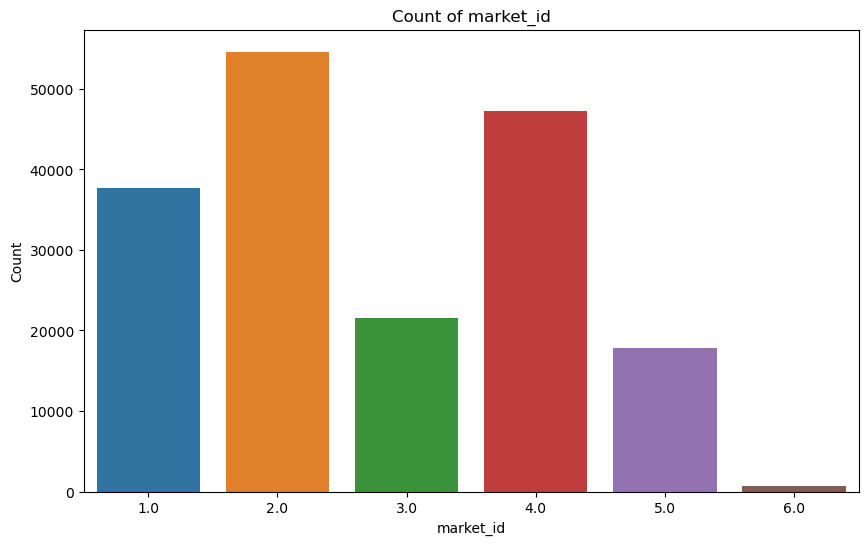

market_id
2.0    54621
4.0    47242
1.0    37695
3.0    21597
5.0    17859
6.0      653
Name: count, dtype: int64
------------------


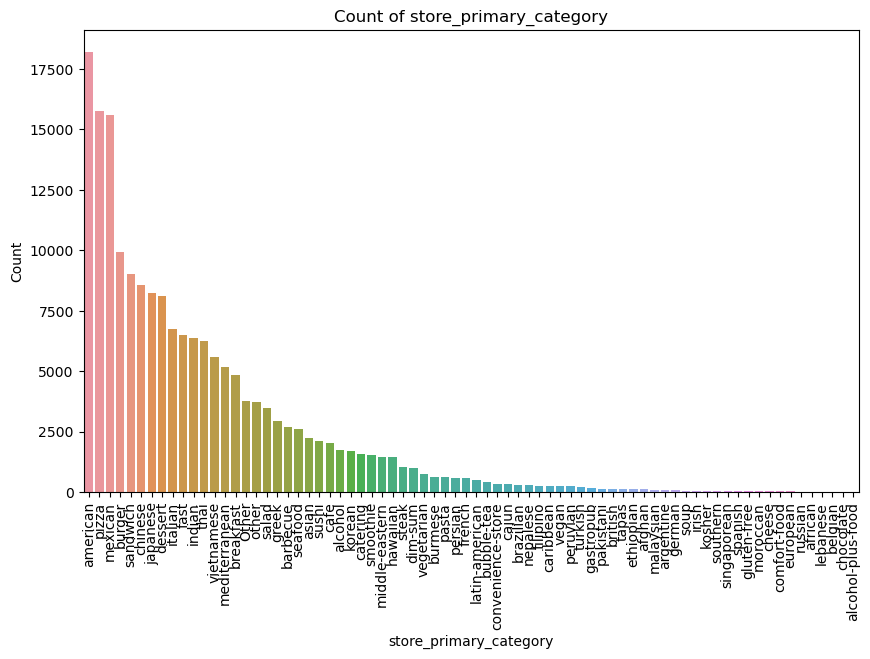

store_primary_category
american             18200
pizza                15762
mexican              15601
burger                9920
sandwich              9001
                     ...  
african                 10
lebanese                 9
belgian                  2
chocolate                1
alcohol-plus-food        1
Name: count, Length: 74, dtype: int64
------------------


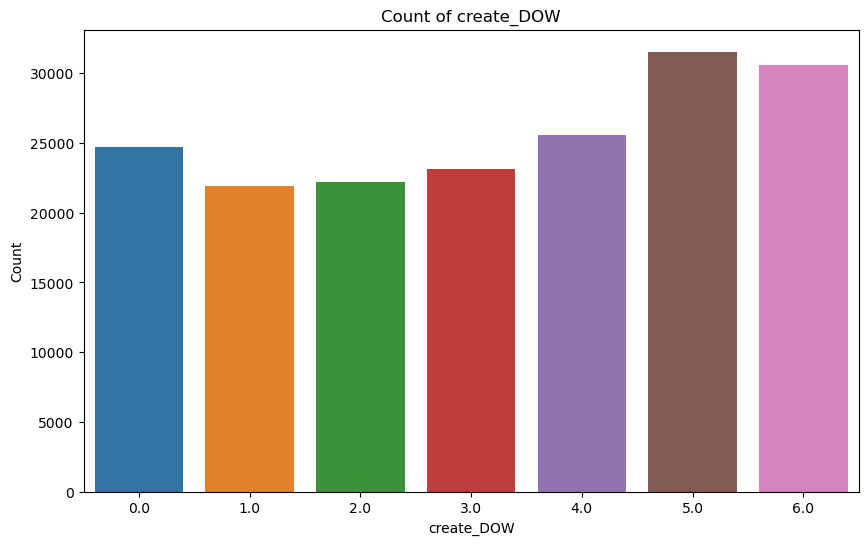

create_DOW
5.0    31533
6.0    30603
4.0    25564
0.0    24715
3.0    23123
2.0    22204
1.0    21925
Name: count, dtype: int64
------------------


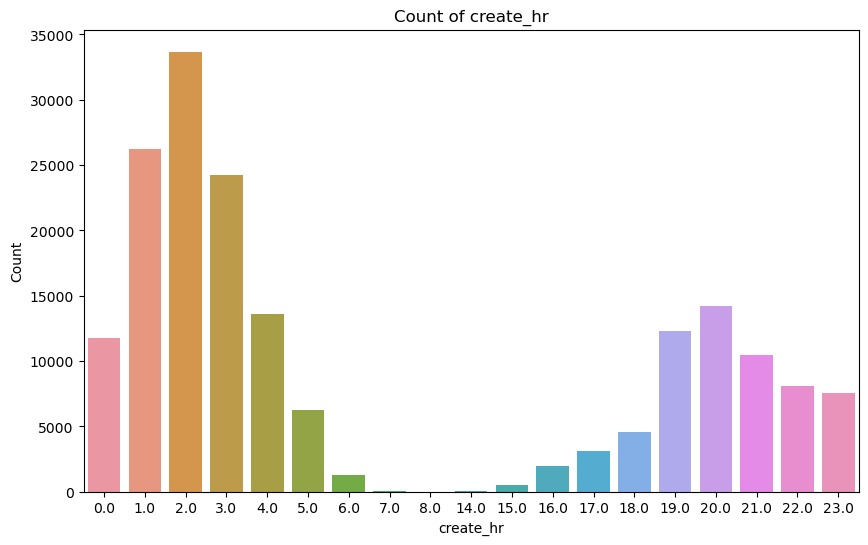

create_hr
2.0     33681
1.0     26247
3.0     24206
20.0    14188
4.0     13566
19.0    12262
0.0     11742
21.0    10460
22.0     8055
23.0     7512
5.0      6237
18.0     4594
17.0     3132
16.0     1976
6.0      1251
15.0      509
14.0       38
7.0         9
8.0         2
Name: count, dtype: int64
------------------


In [75]:
def plot_categorical_counts(df, column):
    df_cat = df[column].value_counts().reset_index()
    df_cat.columns = [column, "count"]

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df_cat, x=column, y="count")
    
    # Rotate x-axis labels for 'store_primary_category' by 90 degrees
    if column == 'store_primary_category':
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    plt.title(f'Count of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

# List of categorical columns to plot
categorical_columns = ['market_id', 'store_primary_category', 'create_DOW', 'create_hr']

# Plot counts for each categorical column
for column in categorical_columns:
    plot_categorical_counts(data, column) 
    print(data[column].value_counts())
    print("------------------")


## Insights from Categorical Exploration

1. **Top Demand Restaurant Categories**: The most in-demand restaurant categories are *American*, *Pizza*, *Mexican*, *Burger*, and *Sandwich*. These categories are known for offering light and easily accessible food options.

2. **Market Demand**: Markets **2** and **4** have the highest delivery demand. This information can help DoorDash allocate resources efficiently and focus on these markets.

3. **Day of the Week**: Most of the delivery demands occur during the **weekend**. Understanding the day-of-week patterns can help plan staffing and delivery resources accordingly.

4. **Created Hour Patterns**: There are three distinct patterns in demand based on the created hour:
   - *0 am to 5 am*: Late-night and early morning orders.
   - *6 am to 3 pm*: Orders during the daytime.
   - *4 pm to 11 pm*: Evening and dinner orders.

These insights provide valuable information for DoorDash's business operations and customer experience optimization.

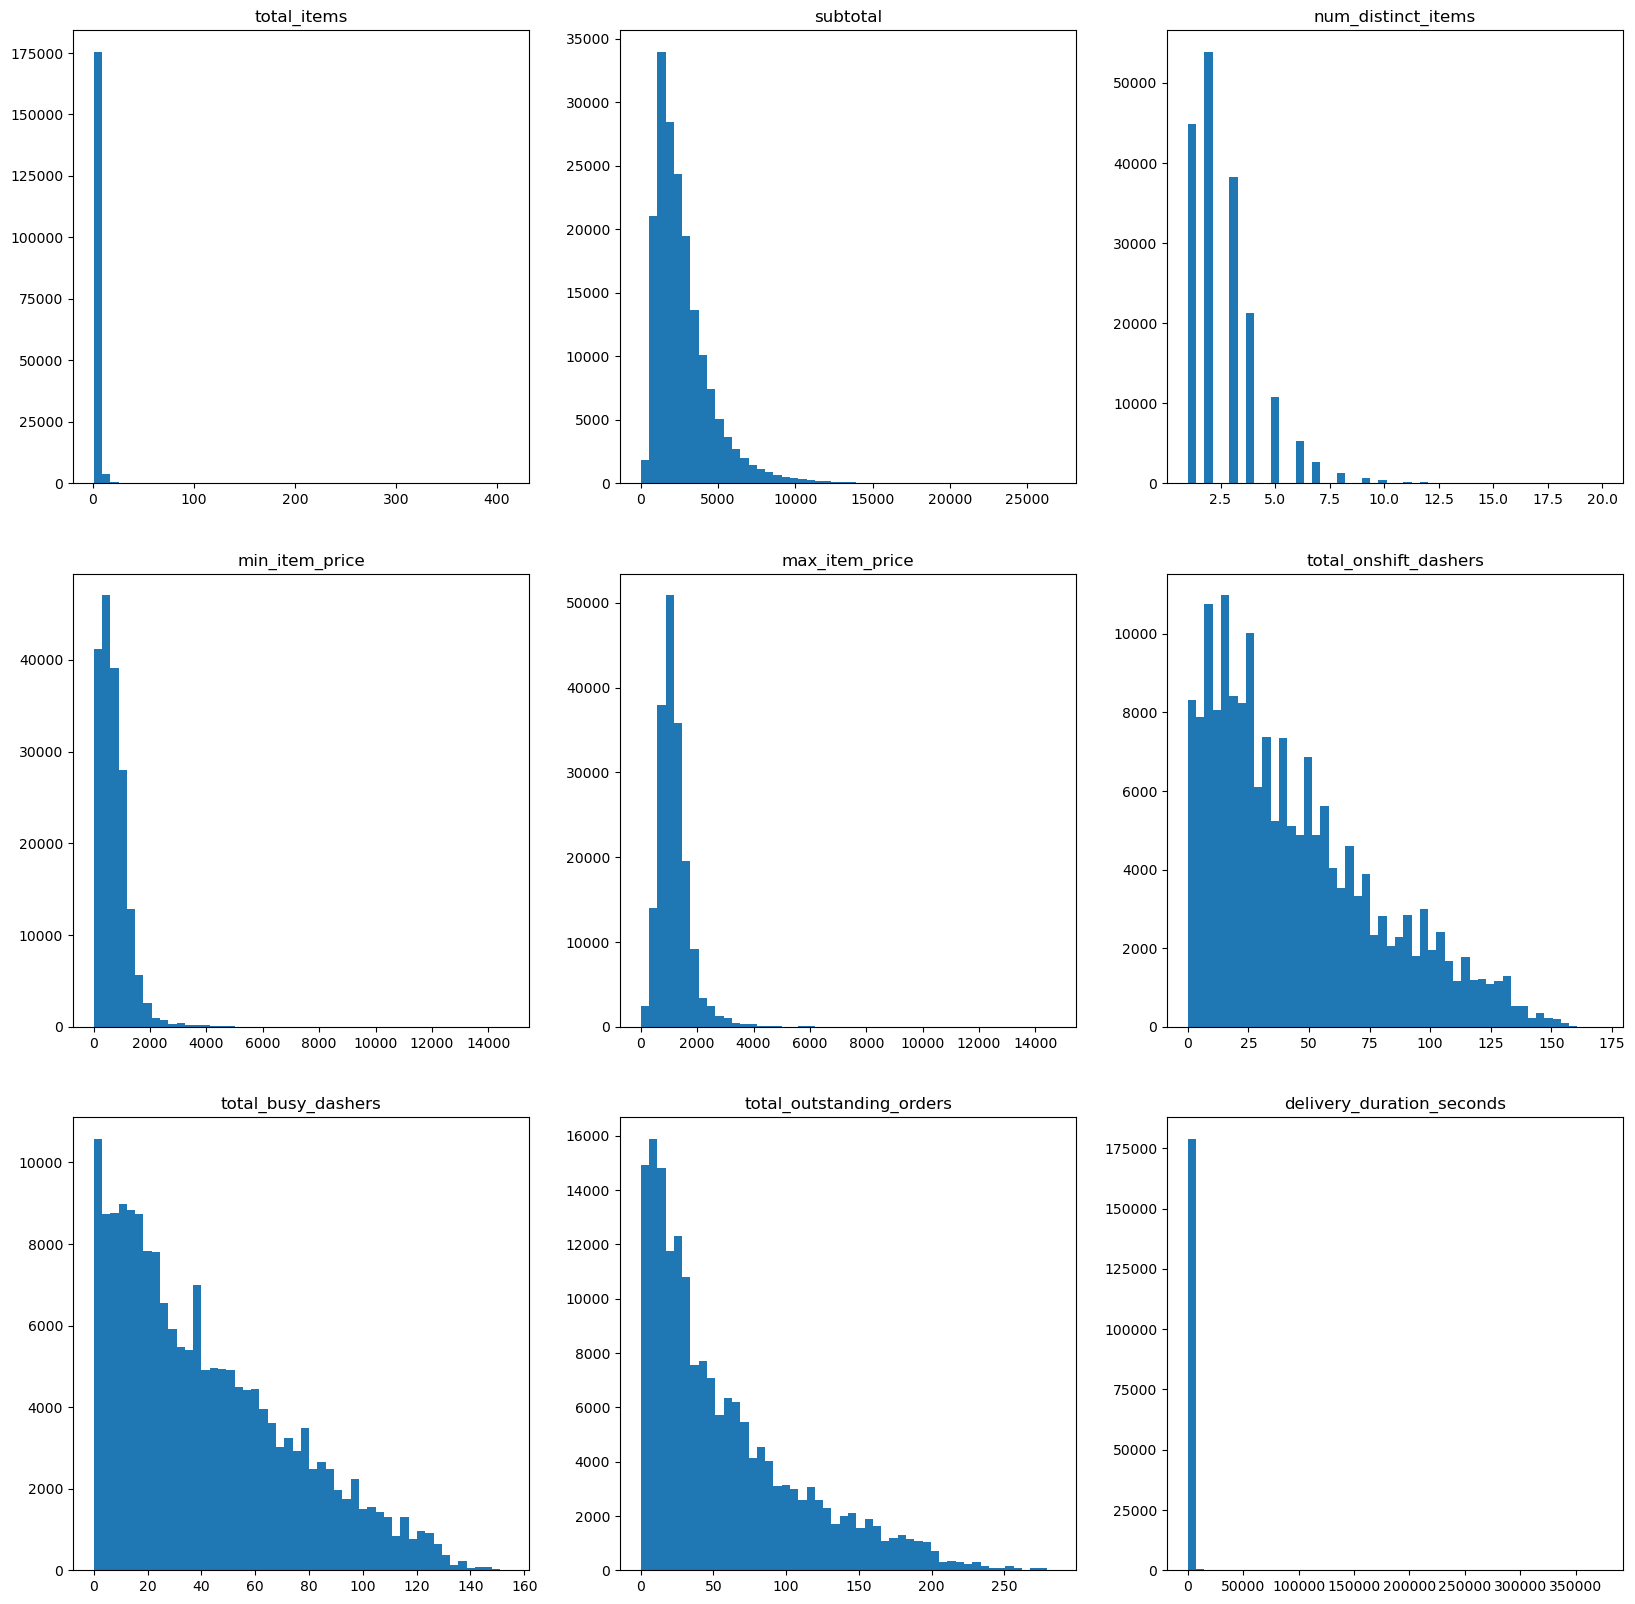

In [76]:
# List of numerical columns to visualize
numerical_columns = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
                     'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'delivery_duration_seconds']

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

# Iterate through numerical columns and plot histograms
for i, column in enumerate(numerical_columns):
    row = i // 3
    col = i % 3
    axes[row][col].hist(data[column], bins=50)
    axes[row][col].set_title(column)

# Display the subplots
plt.show()

## Insights from Numerical Data Exploration

1. **Skewed Distributions**: The numerical columns in the dataset exhibit left-skewed distributions. This suggests that the majority of data points are concentrated on the lower end of the scale.

2. **Total Items**: Most deliveries have a total of fewer than 20 items per order. This indicates that smaller orders are more common on the DoorDash platform.

3. **Number of Distinct Items**: In the dataset, the number of distinct items in most orders is less than 7. This observation implies that orders typically consist of a limited variety of items.

These insights are important for understanding the distribution of data and can inform various aspects of DoorDash's business operations and decision-making processes.


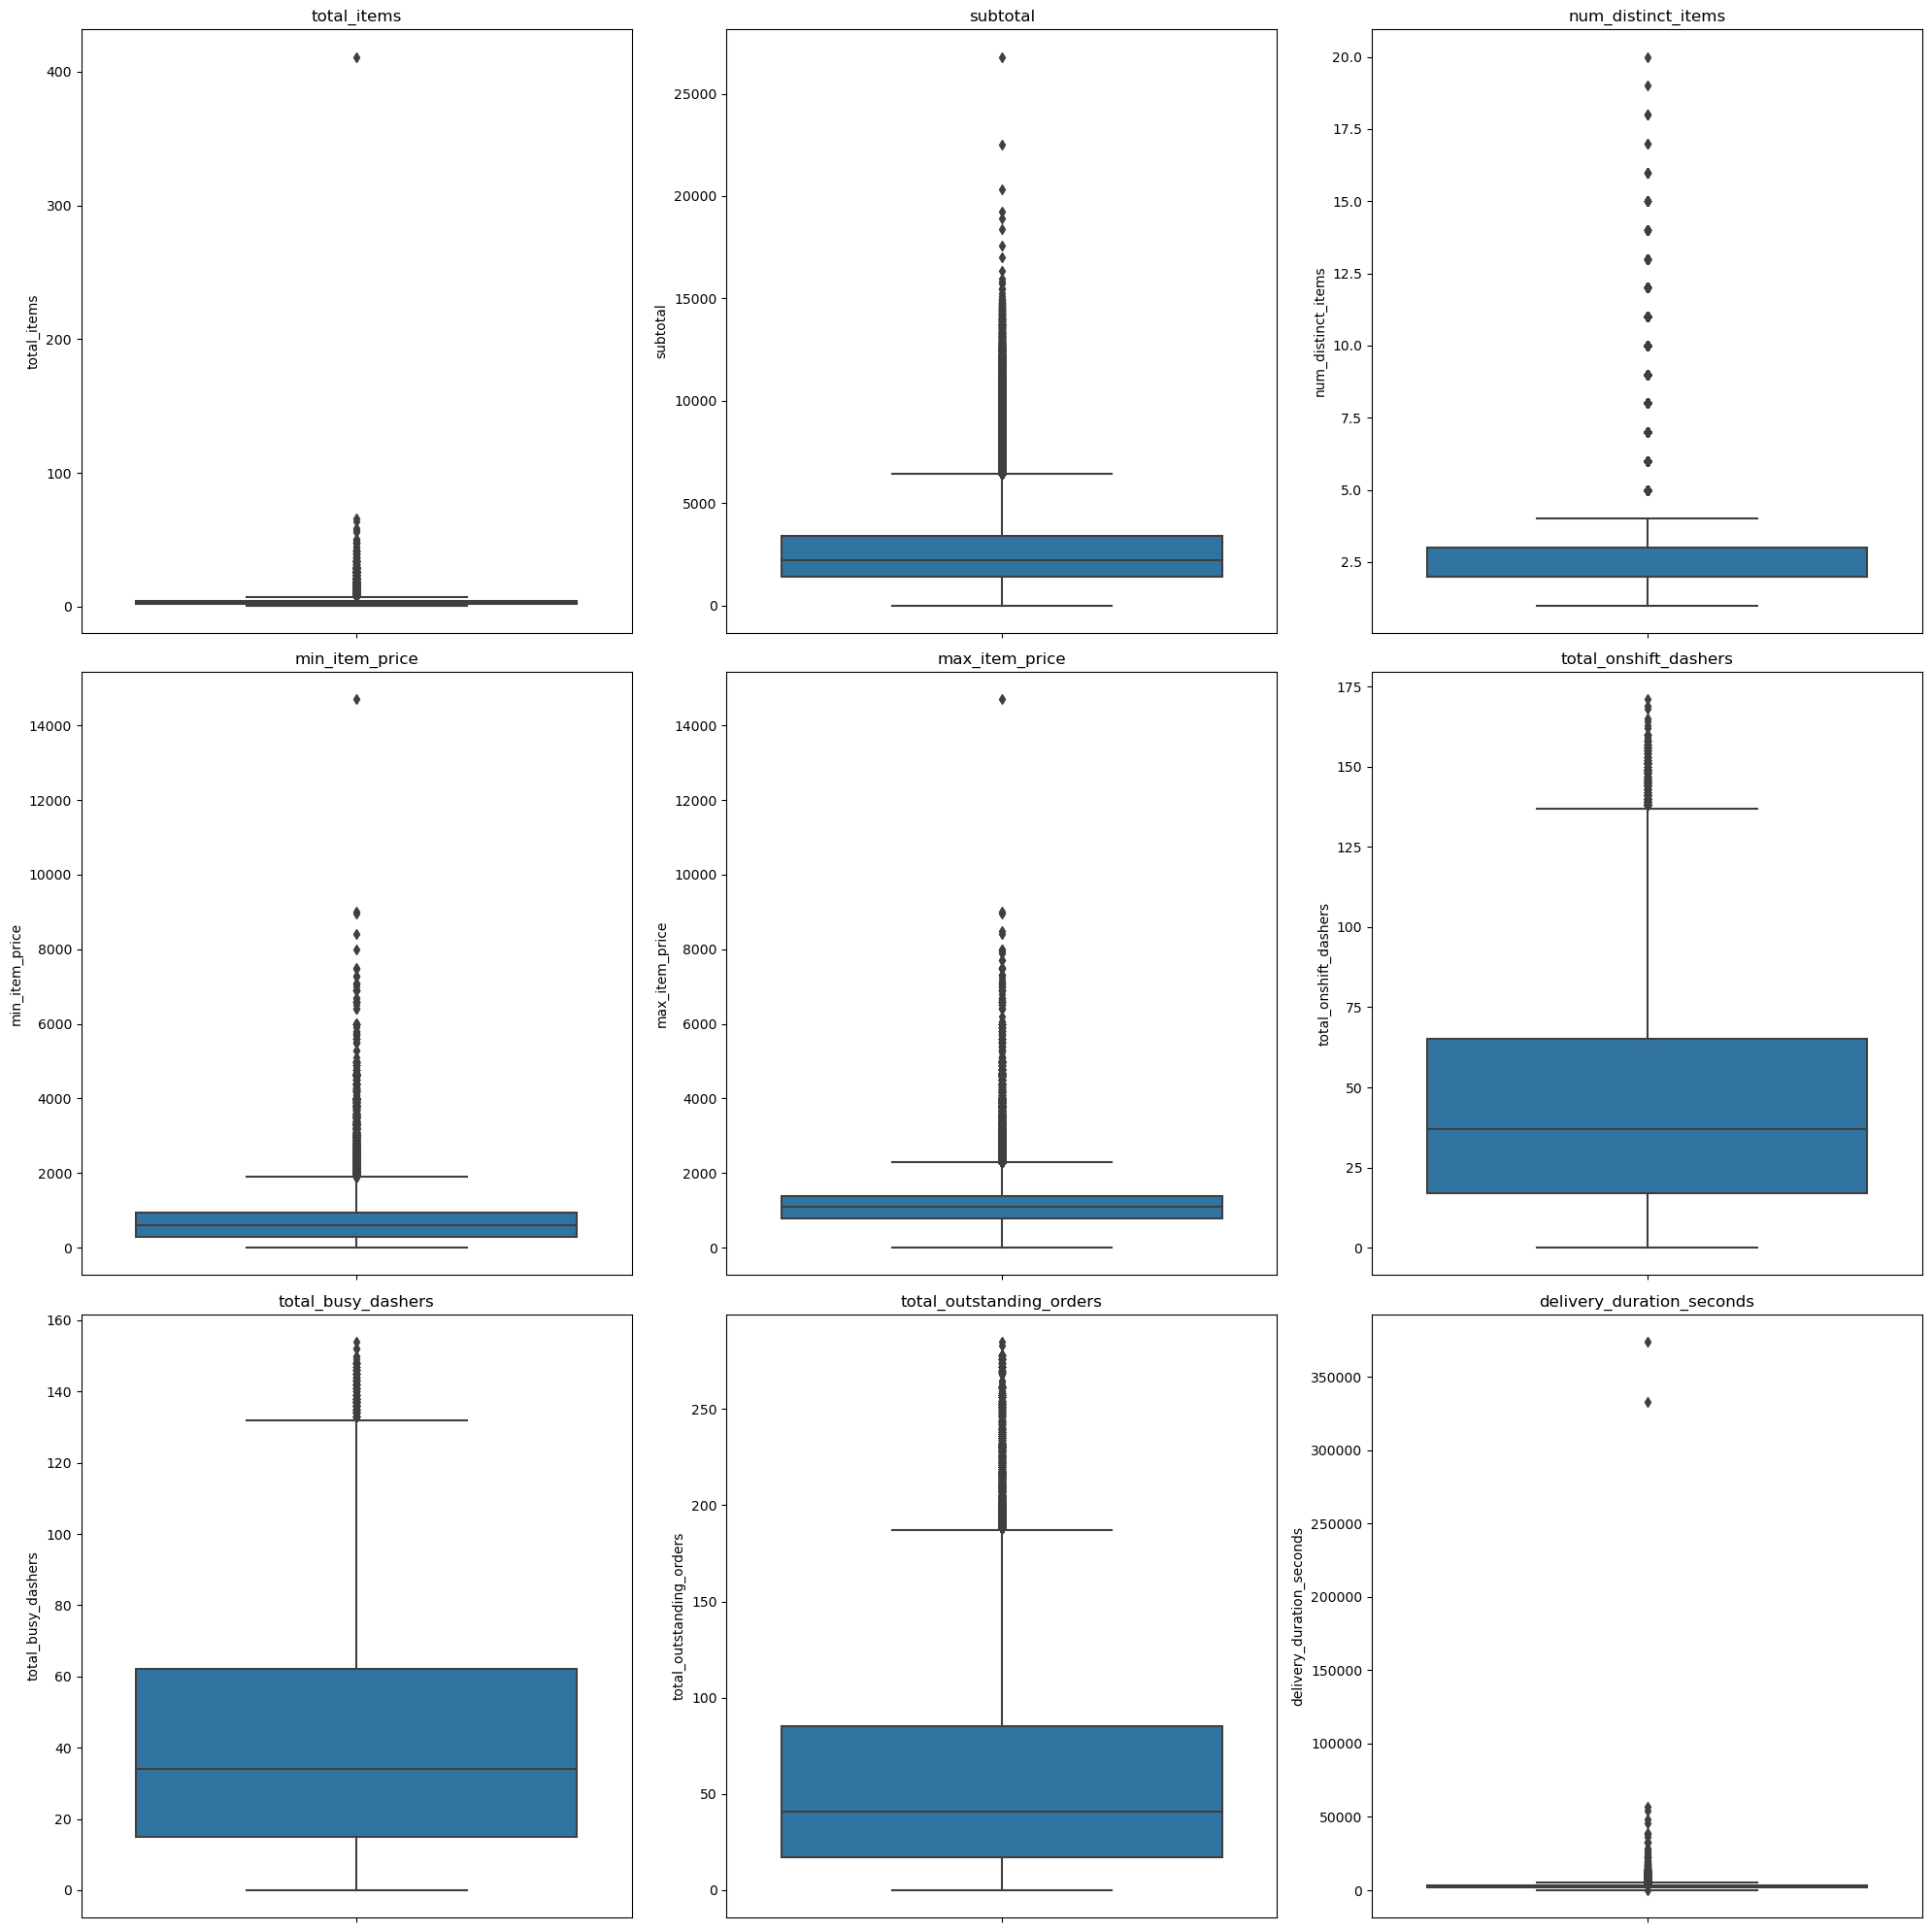

In [77]:
# List of numerical columns to visualize
numerical_columns = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
                     'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'delivery_duration_seconds']

# Create a subplot grid
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

# Iterate through numerical columns and create box plots
for i, column in enumerate(numerical_columns):
    row = i // 3
    col = i % 3
    sns.boxplot(data=data, y=column, ax=axes[row][col])
    axes[row][col].set_title(column)

# Adjust subplot layout
plt.tight_layout()

# Display the box plots
plt.show()

## Presence of Outliers in Numerical Columns

In the analysis of the numerical columns, it has been observed that there is a significant presence of outliers. Outliers are data points that deviate significantly from the majority of the data and can have a substantial impact on statistical measures and machine learning models.

The presence of outliers raises important considerations for data analysis and modeling:

1. **Data Quality**: It's essential to assess whether the outliers are valid and meaningful data points or if they are indicative of data quality issues or anomalies.

2. **Modeling Impact**: Outliers can influence the results of statistical analysis and machine learning models. Decisions need to be made on how to handle these outliers based on the project's goals.

3. **Handling Outliers**: Common approaches to handling outliers include leaving them as-is if they provide valuable insights, removing them if they are data anomalies, transforming the data to reduce their impact, or using robust statistical methods.

In [78]:
# List of numerical columns for which you want to calculate the IQR
numerical_columns = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
                     'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'delivery_duration_seconds']

# Calculate the IQR for each numeric column
Q1 = data[numerical_columns].quantile(0.25)
Q3 = data[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a boolean mask for outliers
outliers_mask = ((data[numerical_columns] < lower_bound) | (data[numerical_columns] > upper_bound)).any(axis=1)

# Remove rows with outliers
data_cleaned = data[~outliers_mask]

# Print the shape of the cleaned DataFrame to see how many rows were removed
print("Original shape:", data.shape)
print("Shape after removing outliers:", data_cleaned.shape)

Original shape: (179667, 19)
Shape after removing outliers: (138863, 19)


In [79]:
# Save the cleaned DataFrame to a CSV file
data_cleaned.to_csv('data_cleaned.csv', index=False)

In [80]:
#  Verify that the file has been saved
import os
if os.path.exists('data_cleaned.csv'):
    print("data_cleaned.csv has been saved successfully.")
else:
    print("Failed to save train_data_cleaned.csv.")

data_cleaned.csv has been saved successfully.


In [81]:
# Check for missing values in the data DataFrame
missing_values = data_cleaned.isnull().sum()

# Display columns with missing values and their respective counts
print("Columns with Missing Values:")
print(missing_values[missing_values > 0])

Columns with Missing Values:
Series([], dtype: int64)


# Feature Engineering

In [82]:
# Create interaction features
data_cleaned['total_order_value'] = data_cleaned['total_items'] * data_cleaned['subtotal']

# Aggregated Statistics
store_stats = data_cleaned.groupby('store_id').agg({'total_items': ['mean', 'median', 'std']}).reset_index()
store_stats.columns = ['store_id', 'mean_total_items', 'median_total_items', 'std_total_items']

market_stats = data_cleaned.groupby('market_id').agg({'total_items': ['mean', 'median', 'std']}).reset_index()
market_stats.columns = ['market_id', 'mean_total_items', 'median_total_items', 'std_total_items']

data_cleaned = pd.merge(data_cleaned, store_stats, on='store_id', how='left')
data_cleaned = pd.merge(data_cleaned, market_stats, on='market_id', how='left')

# Price Features
data_cleaned['price_difference'] = data_cleaned['max_item_price'] - data_cleaned['min_item_price']

# Dashers Features
data_cleaned['dashers_difference'] = data_cleaned['total_onshift_dashers'] - data_cleaned['total_busy_dashers']

# Delivery Density
store_delivery_density = data_cleaned.groupby('store_id').size() / data_cleaned['store_id'].nunique()
data_cleaned['store_delivery_density'] = data_cleaned['store_id'].map(store_delivery_density)

market_delivery_density = data_cleaned.groupby('market_id').size() / data_cleaned['market_id'].nunique()
data_cleaned['market_delivery_density'] = data_cleaned['market_id'].map(market_delivery_density)

# Non-preparation Duration
data_cleaned['non_preparation_duration'] = (
    data_cleaned['estimated_store_to_consumer_driving_duration'] + data_cleaned['estimated_order_place_duration']
)

In [83]:
# Check for missing values in the data DataFrame
missing_values = data_cleaned.isnull().sum()

# Display columns with missing values and their respective counts
print("Columns with Missing Values:")
print(missing_values[missing_values > 0])

Columns with Missing Values:
std_total_items_x    554
dtype: int64


In [84]:
data_cleaned.dropna(subset=['std_total_items_x'], inplace=True)

In [85]:
data_cleaned.loc[data_cleaned['dashers_difference'] < 0, 'dashers_difference'] = 0

In [86]:
data_cleaned.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,median_total_items_x,std_total_items_x,mean_total_items_y,median_total_items_y,std_total_items_y,price_difference,dashers_difference,store_delivery_density,market_delivery_density,non_preparation_duration
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477.0,mexican,2.0,1.0,1900.0,1.0,1400.0,...,3.0,1.333333,2.525891,2.0,1.263679,0.0,0.0,0.001609,6933.0,1136.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477.0,Other,1.0,1.0,1900.0,1.0,1900.0,...,3.0,1.333333,2.554447,2.0,1.273569,0.0,1.0,0.001609,2906.5,1136.0
3,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477.0,Other,1.0,3.0,3900.0,3.0,1100.0,...,3.0,1.333333,2.554447,2.0,1.273569,500.0,0.0,0.001609,2906.5,1096.0
4,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,5477.0,Other,1.0,3.0,5000.0,3.0,1500.0,...,3.0,1.333333,2.554447,2.0,1.273569,400.0,0.0,0.001609,2906.5,784.0
5,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,5477.0,Other,1.0,4.0,4850.0,4.0,750.0,...,3.0,1.333333,2.554447,2.0,1.273569,1050.0,0.0,0.001609,2906.5,1072.0


## Collinearity and Removing Redundancies

In [87]:
store_primary_category = data_cleaned["store_primary_category"].nunique()
print(f"Unique Store Primary Categories: {store_primary_category}")

Unique Store Primary Categories: 72


In [88]:
# Drop the "store_primary_category" column from the DataFrame
data_cleaned.drop(columns=['store_primary_category'], inplace=True)

### Dropping the "store_primary_category" Column

In the context of the dataset and analysis goals, I have identified the "store_primary_category" column as a source of high dimensionality, with 72 unique categories. After careful consideration, I have decided to drop this column as a solution to address the challenges associated with its high dimensionality. 

Here's the rationale for this decision:

Lack of Discriminatory Power: 

Upon review, it appears that the "store_primary_category" column may not provide substantial discriminatory power or meaningful information for the analysis. The presence of 73 unique categories suggests a wide range of cuisines or restaurant types, which may not be directly relevant to the primary objectives.

Dimensionality Reduction: 

By dropping the "store_primary_category" column, I effectively reduce the dimensionality of our dataset. This simplifies the data, making it more manageable and less prone to overfitting in subsequent modeling or analysis tasks.

Streamlined Analysis: Removing this column helps to focus on the most relevant features and patterns within the remaining data, potentially leading to more interpretable and actionable insights.


In [89]:
# Check for missing values in specific columns
columns_with_missing_values = ['median_total_items_y', 'std_total_items_y']

for column in columns_with_missing_values:
    missing_count = data_cleaned[column].isnull().sum()
    print(f"Column '{column}' has {missing_count} missing values.")

Column 'median_total_items_y' has 0 missing values.
Column 'std_total_items_y' has 0 missing values.


In [92]:
data_cleaned.corr()

,market_id,created_at,actual_delivery_time,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,...,median_total_items_x,std_total_items_x,mean_total_items_y,median_total_items_y,std_total_items_y,price_difference,dashers_difference,store_delivery_density,market_delivery_density,non_preparation_duration
market_id,1.000000,0.028688,0.028632,0.041365,-0.023043,0.002476,-0.008950,0.010607,-0.005238,0.001846,...,0.017356,-0.001146,0.181730,NaN,-0.221831,0.007026,0.126619,0.019052,-0.375853,0.003139
created_at,0.028688,1.000000,0.999999,0.006549,0.001462,-0.005639,-0.009177,-0.005560,0.001231,-0.001730,...,0.003619,-0.005693,-0.021049,NaN,0.008144,-0.002893,0.071688,0.001932,-0.025423,0.007307
actual_delivery_time,0.028632,0.999999,1.000000,0.006542,0.001359,-0.005516,-0.008963,-0.005423,0.001254,-0.001574,...,0.003647,-0.005758,-0.021040,NaN,0.008188,-0.002767,0.071575,0.001857,-0.025469,0.007663
store_id,0.041365,0.006549,0.006542,1.000000,0.020064,-0.006713,-0.001845,-0.006235,0.002414,-0.004235,...,-0.037107,-0.005064,0.011517,NaN,-0.019172,-0.006479,0.001733,0.043552,0.002801,0.003502
order_protocol,-0.023043,0.001462,0.001359,0.020064,1.000000,-0.016269,-0.051713,-0.035234,-0.030998,-0.077399,...,-0.052391,0.062495,0.045897,NaN,-0.138552,-0.042984,0.051659,0.359431,0.168454,-0.267129
total_items,0.002476,-0.005639,-0.005516,-0.006713,-0.016269,1.000000,0.597165,0.837360,-0.523580,-0.032090,...,0.320438,0.179306,0.012948,NaN,-0.002976,0.494983,0.027837,-0.038236,0.001021,0.020773
subtotal,-0.008950,-0.009177,-0.008963,-0.001845,-0.051713,0.597165,1.000000,0.586611,0.112649,0.586464,...,0.090581,-0.084501,0.044828,NaN,-0.030914,0.448418,0.061854,-0.023008,0.030223,0.048619
num_distinct_items,0.010607,-0.005560,-0.005423,-0.006235,-0.035234,0.837360,0.586611,1.000000,-0.513456,0.095630,...,0.293369,0.080677,0.015578,NaN,-0.007045,0.607107,0.034871,-0.045154,-0.000109,0.031983
min_item_price,-0.005238,0.001231,0.001254,0.002414,-0.030998,-0.523580,0.112649,-0.513456,1.000000,0.481037,...,-0.224226,-0.204451,0.021438,NaN,-0.021475,-0.543484,0.016457,0.004015,0.018852,0.013157
max_item_price,0.001846,-0.001730,-0.001574,-0.004235,-0.077399,-0.032090,0.586464,0.095630,0.481037,1.000000,...,-0.092658,-0.215316,0.034324,NaN,-0.051747,0.474483,0.061916,-0.020946,0.045277,0.049073


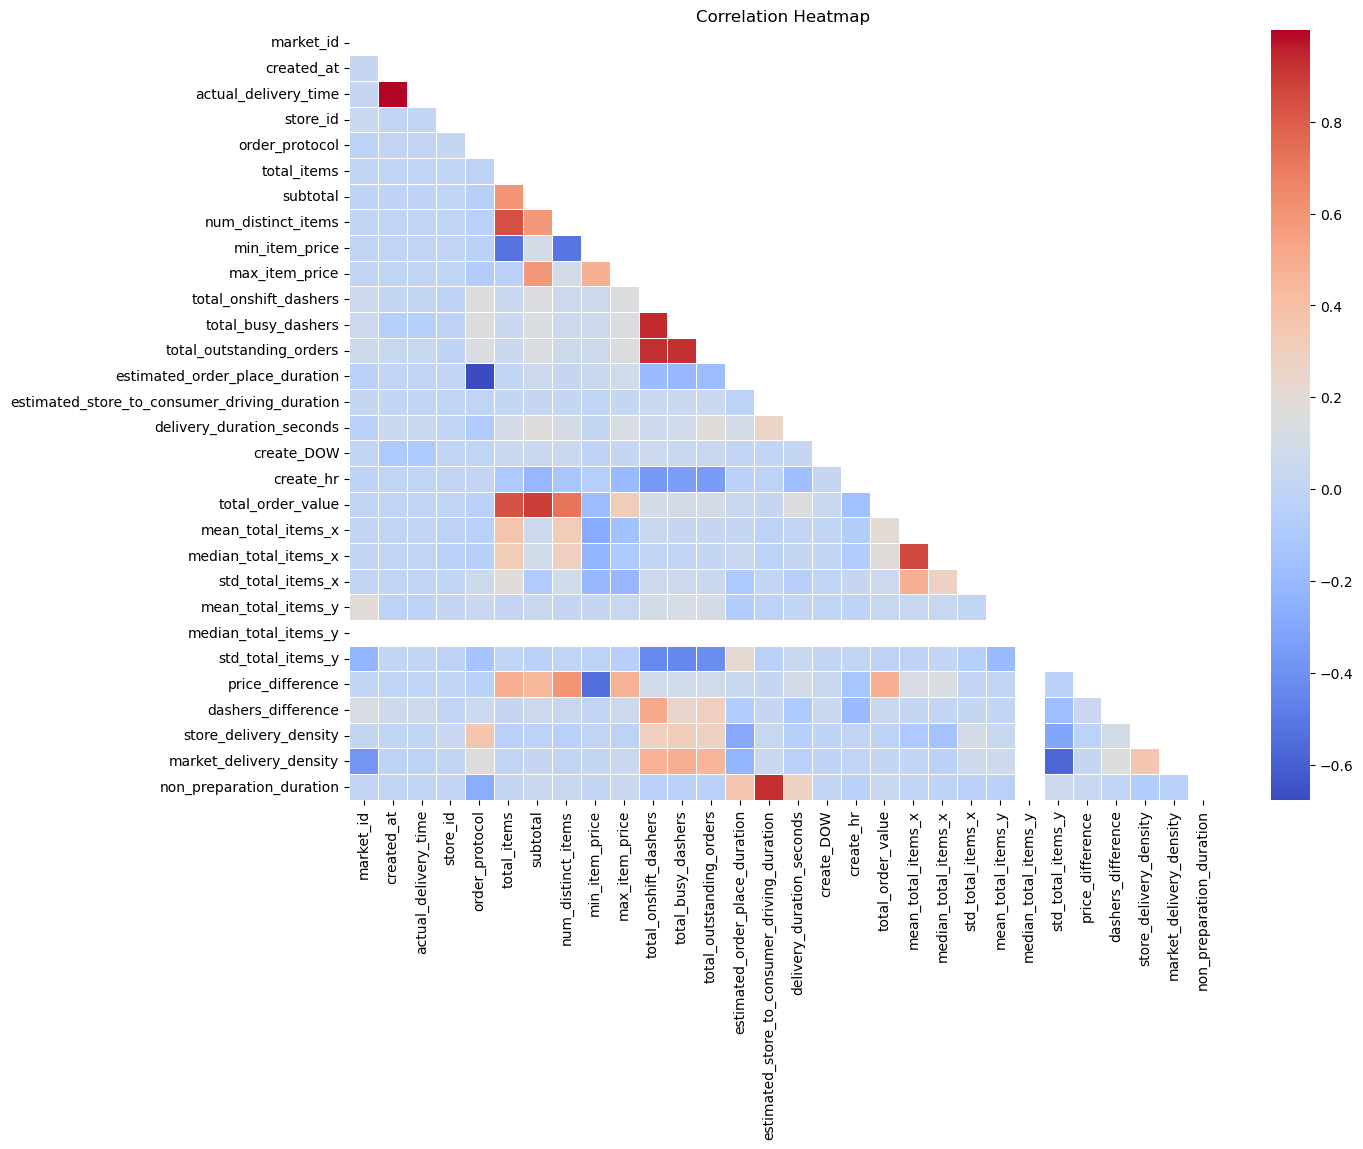

In [95]:
# Compute the correlation matrix (assuming data_cleaned contains your data)
correlation_matrix = data_cleaned.corr()

# Set the size of the heatmap
plt.figure(figsize=(14, 10))

# Create a mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap of the correlation matrix with the mask
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5, mask=mask)

# Set the title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

# Interpretation of Correlation Heatmap

The correlation heatmap provides insight into the relationships between different variables in your dataset. In a correlation heatmap, values closer to 1 indicate a strong positive correlation, values closer to -1 indicate a strong negative correlation, and values close to 0 indicate a weak or no correlation between the variables.

## Market-related Features
- **market_id**: This variable has weak positive correlations with various other features like `store_id`, `total_onshift_dashers`, `total_busy_dashers`, `total_outstanding_orders`, and `market_delivery_density`. These correlations are relatively small, indicating weak associations.

## Time-related Features
- **created_at** and **actual_delivery_time** have a very strong positive correlation (close to 1), which is expected since `actual_delivery_time` is typically derived from `created_at`.
- **create_DOW** (Day of the Week) and **create_hr** (Hour of the Day) have negative correlations with several features, suggesting that certain times of the week or day may have an impact on the data.

## Store and Order-related Features
- **store_id** shows a very weak positive correlation with `order_protocol` and `store_delivery_density`.
- **order_protocol** has negative correlations with several features, including `total_items`, `subtotal`, and `total_outstanding_orders`.

## Item-related Features
- **total_items** and **subtotal** are highly positively correlated, indicating that as the total number of items in an order increases, the subtotal also tends to increase.
- **num_distinct_items** is positively correlated with `total_items` and `subtotal`, suggesting that as the number of distinct items in an order increases, both the total number of items and subtotal tend to increase.
- **min_item_price** and **max_item_price** have positive correlations with `subtotal`, indicating that higher-priced items are associated with larger order subtotals.

## Driver-related Features
- **total_onshift_dashers** and **total_busy_dashers** are positively correlated with each other, which is expected.
- Both of these variables have negative correlations with `price_difference`, indicating that when there are more available and busy dashers, the price difference tends to be lower.

## Delivery-related Features
- **estimated_order_place_duration**, **estimated_store_to_consumer_driving_duration**, and **delivery_duration_seconds** have correlations with various features. These may indicate relationships between order preparation times, driving durations, and delivery times.

## Other Features
- **median_total_items_x**, **std_total_items_x**, **mean_total_items_y**, **median_total_items_y**, **std_total_items_y**, **price_difference**, **dashers_difference**, **store_delivery_density**, **market_delivery_density**, and **non_preparation_duration** have correlations with other features, and these relationships may require further investigation to understand their significance.

Overall, the correlation matrix provides initial insights into feature relationships, but further analysis and modeling are necessary to uncover more complex interactions and patterns in the data. Keep in mind that correlation does not imply causation. Additionally, the NaN values in some cells indicate that there might be insufficient variation in the corresponding variables for meaningful correlation analysis.

In [46]:
def get_top_abs_correlations(df, n=5):
    """
    Get the top N absolute correlations from a DataFrame, excluding identical column pairs.
    
    Parameters:
    - df: DataFrame
        The input DataFrame.
    - n: int (default=5)
        Number of top absolute correlations to return.
    
    Returns:
    - correlations: DataFrame
        A DataFrame containing the top N absolute correlations along with the corresponding pairs.
    """
    # Calculate the absolute correlation matrix
    corr_matrix = df.corr().abs()
    
    # Exclude identical column pairs (diagonal and lower triangular)
    mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    corr_matrix = corr_matrix.where(mask)
    
    # Create an unstacked series of correlations with pairs as the index
    unstacked_corrs = corr_matrix.unstack()
    
    # Sort the correlations in descending order
    sorted_corrs = unstacked_corrs.sort_values(ascending=False)
    
    # Get the top N correlations
    top_corrs = sorted_corrs[:n]
    
    # Create a DataFrame to store the top correlations and their pairs
    correlations = pd.DataFrame(top_corrs, columns=['Correlation'])
    correlations.reset_index(inplace=True)
    
    return correlations

# Get the top 20 absolute correlations (excluding identical column pairs)
top_correlations = get_top_abs_correlations(data_cleaned, n=20)

# Print the top correlations
print("Top Absolute Correlations (Top 20):")
print(top_correlations)

Top Absolute Correlations (Top 20):
                           level_0  \
0             actual_delivery_time   
1               total_busy_dashers   
2         total_outstanding_orders   
3         total_outstanding_orders   
4         non_preparation_duration   
5                total_order_value   
6             median_total_items_x   
7               num_distinct_items   
8                total_order_value   
9                total_order_value   
10  estimated_order_place_duration   
11                price_difference   
12                        subtotal   
13              num_distinct_items   
14                  max_item_price   
15         market_delivery_density   
16                price_difference   
17                  min_item_price   
18                  min_item_price   
19              dashers_difference   

                                         level_1  Correlation  
0                                     created_at     0.999999  
1                          total_onsh

In [48]:
columns_to_remove = [
    "created_at",
    "actual_delivery_time",
    "store_id",
    "total_items",
    "min_item_price",
    "total_order_value",
    "mean_total_items_x",
    "median_total_items_x"
]

data_cleaned = data_cleaned.drop(columns=columns_to_remove)

In [49]:
data_cleaned

,market_id,order_protocol,subtotal,num_distinct_items,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,create_hr,std_total_items_x,mean_total_items_y,median_total_items_y,std_total_items_y,price_difference,dashers_difference,store_delivery_density,market_delivery_density,non_preparation_duration
1,2.0,2.0,1900.0,1.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,21.0,1.333333,2.525891,2.0,1.263679,0.0,0.0,0.001609,6933.0,1136.0
2,3.0,1.0,1900.0,1.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,20.0,1.333333,2.554447,2.0,1.273569,0.0,1.0,0.001609,2906.5,1136.0
3,3.0,1.0,3900.0,3.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,2.0,1.333333,2.554447,2.0,1.273569,500.0,0.0,0.001609,2906.5,1096.0
4,3.0,1.0,5000.0,3.0,1900.0,2.0,2.0,2.0,446.0,338.0,...,20.0,1.333333,2.554447,2.0,1.273569,400.0,0.0,0.001609,2906.5,784.0
5,3.0,1.0,4850.0,4.0,1800.0,7.0,8.0,7.0,446.0,626.0,...,3.0,1.333333,2.554447,2.0,1.273569,1050.0,0.0,0.001609,2906.5,1072.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138858,1.0,4.0,1389.0,3.0,649.0,17.0,17.0,23.0,251.0,331.0,...,0.0,1.604190,2.532253,2.0,1.267998,304.0,0.0,0.011800,4842.0,582.0
138859,1.0,4.0,3010.0,4.0,825.0,12.0,11.0,14.0,251.0,915.0,...,0.0,1.604190,2.532253,2.0,1.267998,420.0,1.0,0.011800,4842.0,1166.0
138860,1.0,4.0,1836.0,3.0,399.0,39.0,41.0,40.0,251.0,795.0,...,4.0,1.604190,2.532253,2.0,1.267998,99.0,0.0,0.011800,4842.0,1046.0
138861,1.0,1.0,1175.0,1.0,535.0,7.0,7.0,12.0,446.0,384.0,...,18.0,2.121320,2.532253,2.0,1.267998,0.0,0.0,0.000358,4842.0,830.0


# Machine Learning Models

In [50]:
# Split the cleaned data into training (80%) and testing (20%) sets
train_data, test_data = train_test_split(data_cleaned, test_size=0.2, random_state=42)

# Save the training and testing datasets as CSV files
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (110647, 22)
Testing data shape: (27662, 22)


### Linear Regression

In [544]:
# Define a custom transformer to add a constant (intercept) to the feature matrix
class AddConstantTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return sm.add_constant(X)

# Define a function to calculate MAE, MAPE, RMSE, and other metrics
def calculate_metrics(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    
    return mae, mape, rmse

# Load training data
train_data = pd.read_csv("train_data.csv")

# Split the data into features (X_train) and the target variable (y_train)
X_train = train_data.drop(columns=["delivery_duration_seconds"])
y_train = train_data["delivery_duration_seconds"]

# Add a constant (intercept) to the feature matrix
X_train = sm.add_constant(X_train)

# Fit the full model (with all variables)
model = sm.OLS(y_train, X_train).fit()

# Perform Backward Elimination
# Define a significance level (e.g., 0.05)
significance_level = 0.05

while True:
    # Get the p-values for all variables
    p_values = model.pvalues[1:]  # Exclude the constant term

    # Find the variable with the highest p-value
    max_p_value = p_values.max()
    max_p_value_idx = p_values.idxmax()  # Index of the variable with the highest p-value

    # Check if the highest p-value is above the significance level
    if max_p_value > significance_level:
        # Remove the variable with the highest p-value from X_train
        X_train = X_train.drop(max_p_value_idx, axis=1)
        model = sm.OLS(y_train, X_train).fit()
    else:
        # If the highest p-value is below the significance level, stop the loop
        break

# Step 4: Final Model
final_model = model

# Print the summary of the final model
print(final_model.summary())

# Create a pipeline for further preprocessing and evaluation metrics
pipeline = Pipeline([
    ('add_constant', AddConstantTransformer()),  # Add a constant to X_train
    ('scaler', StandardScaler()),  # Fit and transform the data using StandardScaler
])

# Fit and transform X_train using the pipeline
X_train_transformed = pipeline.fit_transform(X_train, y_train)

# Make predictions on the training data
y_train_pred = final_model.predict(X_train)

# Calculate and print evaluation metrics
mae, mape, rmse = calculate_metrics(y_train, y_train_pred)
print("MAE:", mae)
print("MAPE:", mape, "%")
print("RMSE:", rmse)


                                OLS Regression Results                               
Dep. Variable:     delivery_duration_seconds   R-squared:                       0.253
Model:                                   OLS   Adj. R-squared:                  0.253
Method:                        Least Squares   F-statistic:                     2087.
Date:                       Wed, 04 Oct 2023   Prob (F-statistic):               0.00
Time:                               01:28:16   Log-Likelihood:            -8.8964e+05
No. Observations:                     110647   AIC:                         1.779e+06
Df Residuals:                         110628   BIC:                         1.780e+06
Df Model:                                 18                                         
Covariance Type:                   nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

**OLS Regression Results**

- **R-squared:** 0.253
  - The model explains 25.3% of the variability in delivery duration.

- **Predictors:**
  - `market_id`: Higher market_id is associated with shorter delivery times.
  - `subtotal`: Increased subtotal leads to slightly longer delivery times.
  - `total_onshift_dashers`: More on-shift dashers result in shorter delivery times.
  - `total_busy_dashers`: More busy dashers lead to shorter delivery times.
  - `total_outstanding_orders`: More outstanding orders result in longer delivery times.

- **Evaluation Metrics:**
  - **MAE:** 593.68 seconds (mean absolute error)
  - **MAPE:** 24.51% (mean absolute percentage error)
  - **RMSE:** 751.00 seconds (root mean squared error)

- **Model Significance:**
  - The model is statistically significant (F-statistic: 2087.0).

- **Notes:**
  - There may be multicollinearity or singularity issues affecting coefficient estimates.


## Random Forest

In [545]:
# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('rf_regressor', RandomForestRegressor(n_estimators=100, random_state=42)),  # Random Forest Regressor
])

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = pipeline.predict(X_val)

# Evaluate the model using metrics
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r_squared = r2_score(y_val, y_pred)  # Calculate R-squared

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100}%")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R^2): {r_squared}")

# Calculate Gini importance
feature_importances = pipeline.named_steps['rf_regressor'].feature_importances_

Mean Absolute Error (MAE): 576.4427649646032
Mean Absolute Percentage Error (MAPE): 23.734984272238552%
Root Mean Squared Error (RMSE): 733.0349410308563
R-squared (R^2): 0.29854293458820735


market_id: 0.010553513616808022
order_protocol: 0.02138768995402216
subtotal: 0.0978768461557969
num_distinct_items: 0.015765441078903285
total_onshift_dashers: 0.06207056542239428
total_busy_dashers: 0.05695531854777646
total_outstanding_orders: 0.10387438572134336
estimated_order_place_duration: 0.0024110380943337447
estimated_store_to_consumer_driving_duration: 0.0668200562263834
create_DOW: 0.041754718429761806
create_hr: 0.08059691479194976
std_total_items_x: 0.08154281913675683
mean_total_items_y: 0.008075597603616935
median_total_items_y: 0.0
std_total_items_y: 0.011060769963769314
price_difference: 0.05456602375681308
dashers_difference: 0.059258627325418256
store_delivery_density: 0.07316877474991357
market_delivery_density: 0.011144470586845444
non_preparation_duration: 0.14111642883739337


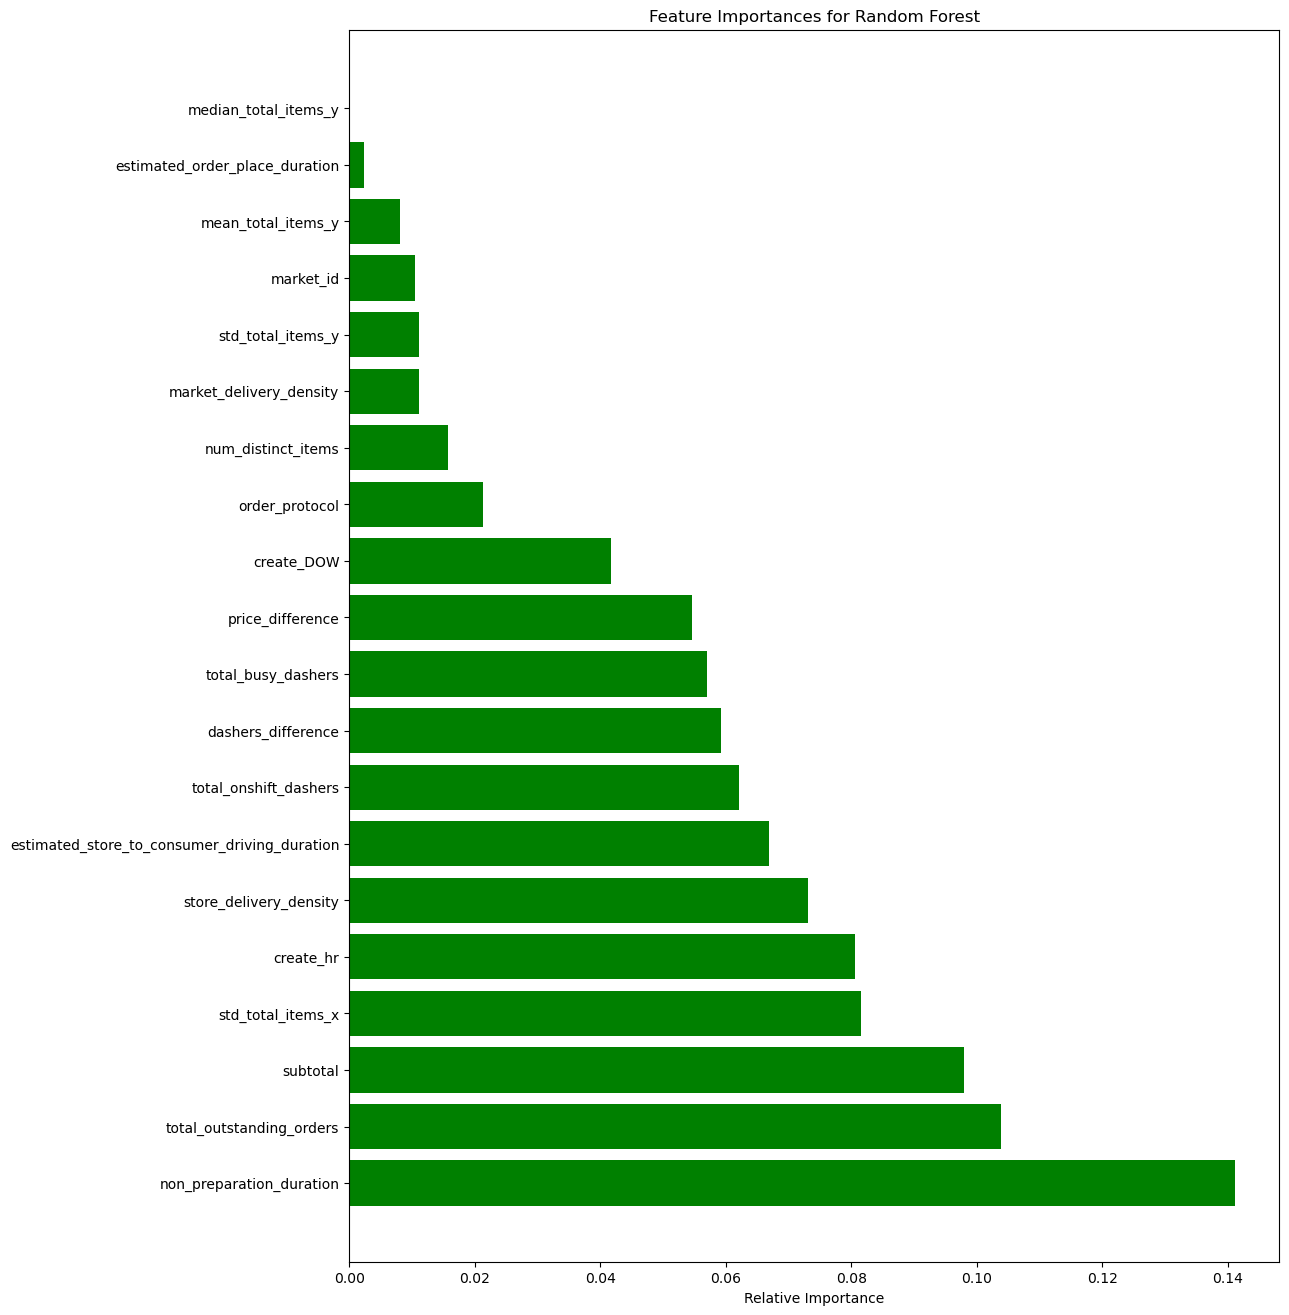

In [546]:
# Calculate Gini importance
feature_importances = pipeline.named_steps['rf_regressor'].feature_importances_

# Print feature importances
for feature_name, importance in zip(X_train.columns, feature_importances):
    print(f"{feature_name}: {importance}")
    
# Get feature names and importances
features = X_train.columns
importances = feature_importances

# Sort feature importances in descending order
indices = importances.argsort()[::-1]

# Create a bar chart with the specified style
plt.figure(figsize=(12, 16))
plt.title('Feature Importances for Random Forest')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

### Hyperparameter Tuning of Random Forest

In [59]:
# Load training data
train_data = pd.read_csv("train_data.csv")

# Split the data into features (X_train) and the target variable (y_train)
X_train = train_data.drop(columns=["delivery_duration_seconds"])
y_train = train_data["delivery_duration_seconds"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create a pipeline with a RandomForestRegressor
pipeline = Pipeline([
    ('rf_regressor', RandomForestRegressor(random_state=42)),  # Random Forest Regressor
])

# Define the hyperparameter distribution for tuning
param_dist = {
    'rf_regressor__n_estimators': randint(100, 150),  # Number of trees (reduced range)
    'rf_regressor__max_depth': [None, 10],  # Max depth of each tree (reduced options)
    'rf_regressor__min_samples_split': randint(2, 4),  # Minimum samples required to split a node (reduced range)
    'rf_regressor__min_samples_leaf': randint(1, 2),  # Minimum samples required at each leaf node (reduced options)
}

# Create a RandomizedSearchCV object with fewer iterations
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,  # Reduce the number of random combinations to try
    scoring='neg_mean_absolute_error',  # Use MAE as the scoring metric
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions on the validation set using the best model
y_pred = best_model.predict(X_val)

# Evaluate the model using metrics
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r_squared = r2_score(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R^2): {r_squared:.2f}")


Best Hyperparameters: {'rf_regressor__max_depth': None, 'rf_regressor__min_samples_leaf': 1, 'rf_regressor__min_samples_split': 3, 'rf_regressor__n_estimators': 146}
Mean Absolute Error (MAE): 575.1523896220981
Mean Absolute Percentage Error (MAPE): 23.69%
Root Mean Squared Error (RMSE): 731.07
R-squared (R^2): 0.30


# XG Boost

In [56]:
# Load training data
train_data = pd.read_csv("train_data.csv")

# Split the data into features (X_train) and the target variable (y_train)
X_train = train_data.drop(columns=["delivery_duration_seconds"])
y_train = train_data["delivery_duration_seconds"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create an XGBoost regressor
xgb_regressor = xgb.XGBRegressor(
    n_estimators=100,  # Number of boosting rounds 
    learning_rate=0.1,  # Learning rate 
    max_depth=3,  # Maximum depth of each tree 
    random_state=42  # Random seed for reproducibility
)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features 
    ('xgb_regressor', xgb_regressor)  # XGBoost Regressor
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = pipeline.predict(X_val)

# Evaluate the model using metrics
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred) * 100
rmse = mean_squared_error(y_val, y_pred, squared=False)
r_squared = r2_score(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R^2): {r_squared:.2f}")


Mean Absolute Error (MAE): 581.3181936892352
Mean Absolute Percentage Error (MAPE): 23.85%
Root Mean Squared Error (RMSE): 739.01
R-squared (R^2): 0.29


### Hyperparameter Tuning of XG Boost

In [33]:
# Load training data
train_data = pd.read_csv("train_data.csv")

# Split the data into features (X_train) and the target variable (y_train)
X = train_data.drop(columns=["delivery_duration_seconds"])
y = train_data["delivery_duration_seconds"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost regressor
xgb_regressor = xgb.XGBRegressor(
    n_estimators=100,  # Number of boosting rounds 
    learning_rate=0.1,  # Learning rate 
    max_depth=3,  # Maximum depth of each tree 
    random_state=42  # Random seed for reproducibility
)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features 
    ('xgb_regressor', xgb_regressor)  # XGBoost Regressor
])

# Define a narrower hyperparameter distribution for tuning
param_dist = {
    'xgb_regressor__n_estimators': randint(100, 200),  # Number of boosting rounds
    'xgb_regressor__max_depth': [3, 5, 7],  # Maximum depth of each tree
    'xgb_regressor__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'xgb_regressor__gamma': [0, 0.1, 0.2],  # Regularization parameter
}

# Create a RandomizedSearchCV object with reduced n_iter
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,  # Reduce the number of iterations
    scoring='neg_mean_absolute_error',  # Use MAE as the scoring metric
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions on the validation set using the best model
y_pred = best_model.predict(X_val)

# Evaluate the model using metrics
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred) * 100
rmse = mean_squared_error(y_val, y_pred, squared=False)
r_squared = r2_score(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R^2): {r_squared:.2f}")


Best Hyperparameters: {'xgb_regressor__gamma': 0.2, 'xgb_regressor__learning_rate': 0.2, 'xgb_regressor__max_depth': 5, 'xgb_regressor__n_estimators': 191}
Mean Absolute Error (MAE): 549.01573692077
Mean Absolute Percentage Error (MAPE): 22.31%
Root Mean Squared Error (RMSE): 704.68
R-squared (R^2): 0.35


# Gradient Boosting

In [60]:
# Load training data
train_data = pd.read_csv("train_data.csv")

# Split the data into features (X) and the target variable (y)
X = train_data.drop(columns=["delivery_duration_seconds"])
y = train_data["delivery_duration_seconds"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(
    n_estimators=100,  # Number of boosting rounds
    learning_rate=0.1,  # Learning rate
    max_depth=3,  # Maximum depth of each tree
    random_state=42  # Random seed for reproducibility
)

# Fit the model to the training data
gb_regressor.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = gb_regressor.predict(X_val)

# Evaluate the model using metrics
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r_squared = r2_score(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R^2): {r_squared:.2f}")

Mean Absolute Error (MAE): 580.6383354123635
Mean Absolute Percentage Error (MAPE): 23.82%
Root Mean Squared Error (RMSE): 738.25
R-squared (R^2): 0.29


### Hyperparameter Tuning of Gradient Boosting

In [104]:
# Load training data
train_data = pd.read_csv("train_data.csv")

# Split the data into features (X_train) and the target variable (y_train)
X = train_data.drop(columns=["delivery_duration_seconds"])
y = train_data["delivery_duration_seconds"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with GradientBoostingRegressor
pipeline = Pipeline([
    ('gb_regressor', GradientBoostingRegressor(random_state=42))
])

# Define the hyperparameter distribution for tuning
param_dist = {
    'gb_regressor__n_estimators': randint(100, 300),  # Number of boosting rounds
    'gb_regressor__learning_rate': uniform(0.01, 0.2),  # Learning rate
    'gb_regressor__max_depth': randint(3, 6),  # Maximum depth of each tree
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    scoring='neg_mean_absolute_error',  # Use MAE as the scoring metric
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
)

# Fit the RandomizedSearchCV to your training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions on the validation set using the best model
y_pred = best_model.predict(X_val)

# Evaluate the model using metrics
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred) * 100
rmse = mean_squared_error(y_val, y_pred, squared=False)
r_squared = r2_score(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R^2): {r_squared:.2f}")

Best Hyperparameters: {'gb_regressor__learning_rate': 0.16107228206353053, 'gb_regressor__max_depth': 4, 'gb_regressor__n_estimators': 233}
Mean Absolute Error (MAE): 551.7010705711516
Mean Absolute Percentage Error (MAPE): 22.45%
Root Mean Squared Error (RMSE): 707.70
R-squared (R^2): 0.35


# Summary of the performance of each model on the train_data

**Linear Regression:**

- MAE: 593.68
- MAPE: 24.51%
- RMSE: 751.00
- R-squared: 0.253

**Hyperparameter Tuned Random Forest:**

- Best Hyperparameters: {'rf_regressor__max_depth': None, 'rf_regressor__min_samples_leaf': 1, 'rf_regressor__min_samples_split': 3, 'rf_regressor__n_estimators': 146}
- MAE: 575.15
- MAPE: 23.69%
- RMSE: 731.07
- R-squared: 0.30

**Hyperparameter Tuned XG Boost:**

- Best Hyperparameters: {'xgb_regressor__gamma': 0.2, 'xgb_regressor__learning_rate': 0.2, 'xgb_regressor__max_depth': 5, 'xgb_regressor__n_estimators': 191}
- MAE: 549.02
- MAPE: 22.31%
- RMSE: 704.68
- R-squared: 0.35

**Hyperparameter Tuned Gradient Boosting:**

- Best Hyperparameters: {'gb_regressor__learning_rate': 0.16107228206353053, 'gb_regressor__max_depth': 4, 'gb_regressor__n_estimators': 233}
- MAE: 551.70
- MAPE: 22.45%
- RMSE: 707.70
- R-squared: 0.35

Based on these metrics, it appears that the Hyperparameter Tuned XG Boost and Hyperparameter Tuned Gradient Boosting models are performing the best, as they have the lowest MAE, MAPE, and RMSE values, as well as the highest R-squared values. I will use the best model for predictions on test_data.

The selected models demonstrate promising performance in delivery time prediction. Further enhancements can be achieved through meticulous fine-tuning, such as exploring hyperparameter adjustments, feature selection, and advanced preprocessing methods. These refinements can potentially bolster the models' accuracy and their ability to adapt to various datasets and scenarios. Continuous optimization remains a valuable prospect for ongoing improvement.


# Predictions on the test data using the hyperparameter-tuned XGBoost model

In [96]:
# Print the keys of named_steps to identify the actual name of the XGBoost regressor
print(best_model.named_steps.keys())

dict_keys(['scaler', 'xgb_regressor'])


In [107]:
# Load the test data from a CSV file
test_data = pd.read_csv('test_data.csv')  # Replace 'your_test_data.csv' with the actual file path

# Assuming you have already trained and obtained the best XGBoost model
best_xgb_model = best_model.named_steps['gb_regressor']

# Separate the features (X_test) and the target variable (y_test)
X_test = test_data.drop(columns=['delivery_duration_seconds'])  # Replace 'target_column_name' with the actual target column name
y_test = test_data['delivery_duration_seconds']  # Replace 'target_column_name' with the actual target column name

# Make predictions on the test set
y_pred_test = best_xgb_model.predict(X_test)

# Evaluate the model using metrics on the test set
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
r_squared_test = r2_score(y_test, y_pred_test)

print("Metrics on the Test Set:")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_test:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.2f}")
print(f"R-squared (R^2): {r_squared_test:.2f}")

Metrics on the Test Set:
Mean Absolute Error (MAE): 552.4293773544786
Mean Absolute Percentage Error (MAPE): 22.70%
Root Mean Squared Error (RMSE): 704.67
R-squared (R^2): 0.34


**Performance Evaluation on Validation Set:**

- Mean Absolute Error (MAE): 549.02
- Mean Absolute Percentage Error (MAPE): 22.31%
- Root Mean Squared Error (RMSE): 704.68
- R-squared (R^2): 0.35

**Performance Evaluation on Test Set:**

- Mean Absolute Error (MAE): 552.43
- Mean Absolute Percentage Error (MAPE): 22.70%
- Root Mean Squared Error (RMSE): 704.67
- R-squared (R^2): 0.34

**Interpretation:**

The XGBoost model demonstrates consistent and good predictive performance on both the validation and test sets. It maintains its ability to make accurate delivery time predictions when applied to new, unseen data. The similarity in performance metrics between the two sets suggests that the model generalizes effectively and reliably predicts delivery times across different datasets. Overall, the XGBoost model's predictive capabilities remain robust and consistent.

# Model Serialization

In [34]:
# Save the best model (including preprocessing steps) to a file
model_file_path = 'delivery_time_model.pkl'
joblib.dump(best_model, model_file_path)

# Print a message to confirm the model is saved
print(f"Model saved to {model_file_path}")

Model saved to delivery_time_model.pkl


# Model Deployment in Flask

In [1]:
!pip install flask joblib xgboost

In [3]:
import os

model_file_path = 'C:/Users/User/Desktop/Lighthouse BootCamp/Delivery_Duration_Prediction_ML_Final_Project/delivery_time_model.pkl'

if os.path.isfile(model_file_path):
    print(f"File '{model_file_path}' exists.")
else:
    print(f"File '{model_file_path}' does not exist.")


File 'C:/Users/User/Desktop/Lighthouse BootCamp/Delivery_Duration_Prediction_ML_Final_Project/delivery_time_model.pkl' exists.


In [5]:
import sys

In [6]:
sys.path

['C:\\Users\\User\\Desktop\\Lighthouse BootCamp\\Delivery_Duration_Prediction_ML_Final_Project',
 'C:\\Users\\User\\anaconda3\\python311.zip',
 'C:\\Users\\User\\anaconda3\\DLLs',
 'C:\\Users\\User\\anaconda3\\Lib',
 'C:\\Users\\User\\anaconda3',
 '',
 'C:\\Users\\User\\anaconda3\\Lib\\site-packages',
 'C:\\Users\\User\\anaconda3\\Lib\\site-packages\\win32',
 'C:\\Users\\User\\anaconda3\\Lib\\site-packages\\win32\\lib',
 'C:\\Users\\User\\anaconda3\\Lib\\site-packages\\Pythonwin']

In [38]:
print(test_data.columns)

Index(['market_id', 'order_protocol', 'subtotal', 'num_distinct_items',
       'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration',
       'delivery_duration_seconds', 'create_DOW', 'create_hr',
       'std_total_items_x', 'mean_total_items_y', 'median_total_items_y',
       'std_total_items_y', 'price_difference', 'dashers_difference',
       'store_delivery_density', 'market_delivery_density',
       'non_preparation_duration'],
      dtype='object')


### Prediction

In [64]:
import requests
import json
import pandas as pd

# Define the API endpoint URL
api_url = "http://127.0.0.1:5000/predict" 

# Load test data from a CSV file
test_data = pd.read_csv("test_data.csv")

# Choose a sample row from test data for testing
sample_row = test_data.iloc[0]  

# Convert the sample row to a dictionary with feature names
sample_data = {
    "features": {
        "market_id": sample_row['market_id'],
        "order_protocol": sample_row['order_protocol'],
        "subtotal": sample_row['subtotal'],
        "num_distinct_items": sample_row['num_distinct_items'],
        "max_item_price": sample_row['max_item_price'],
        "total_onshift_dashers": sample_row['total_onshift_dashers'],
        "total_busy_dashers": sample_row['total_busy_dashers'],
        "total_outstanding_orders": sample_row['total_outstanding_orders'],
        "estimated_order_place_duration": sample_row['estimated_order_place_duration'],
        "estimated_store_to_consumer_driving_duration": sample_row['estimated_store_to_consumer_driving_duration'],
        "create_DOW": sample_row['create_DOW'],
        "create_hr": sample_row['create_hr'],
        "std_total_items_x": sample_row['std_total_items_x'],
        "mean_total_items_y": sample_row['mean_total_items_y'],
        "median_total_items_y": sample_row['median_total_items_y'],
        "std_total_items_y": sample_row['std_total_items_y'],
        "price_difference": sample_row['price_difference'],
        "dashers_difference": sample_row['dashers_difference'],
        "store_delivery_density": sample_row['store_delivery_density'],
        "market_delivery_density": sample_row['market_delivery_density'],
        "non_preparation_duration": sample_row['non_preparation_duration'],
    }
}

# Send a POST request with JSON data
response = requests.post(api_url, json=sample_data)
print(response)

# Check the response status code and handle it as needed
if response.status_code == 200:
    # Parse the JSON response and extract the prediction
    try:
        result = json.loads(response.text)
        prediction = result.get('prediction', 'Prediction key not found in response')
        print(f"Predicted Value: {prediction}")
    except json.JSONDecodeError:
        print("Error decoding JSON response from the API.")
else:
    print(f"Failed to make a prediction. Status code: {response.status_code}")


<Response [200]>
Predicted Value: 2334.3466796875
